In this notebook, we aim to learn neural network functions which are drawn from a hard class of functions in diakonikolas et al. or random neural networks. The input distribution is a low dimensional hypersphere which is one instance of learnable setting.

In [ ]:
import torch
import math

pi = math.pi

def random_orthogonal_matrix(n, k=2):
    # Generate random vectors
    A = torch.randn(n, n)

    # Gram-Schmidt orthogonalization
    Q, _ = torch.qr(A)

    return Q[:,:k]

def draw_normalized_vectors(batch_size, n, B = None):
    vectors = torch.randn((batch_size, n))
    norm = vectors.norm(dim=1, keepdim=True)
    normalized_vectors = vectors / norm
    if B is not None:
        normalized_vectors = normalized_vectors@torch.transpose(B,0,1)
    return normalized_vectors


import torch
from math import pi

class f_B_handler:
    # constructs the target function and normalizes outputs
    def __init__(self, n=50, k=None, d = 10):
        self.n = n
        if k is None:
            self.k = n//4
        else:
            self.k = k
        self.B = random_orthogonal_matrix(n,2)
        self.d = d
        self.D = random_orthogonal_matrix(n,d)

        self.c = self.calculate_norm_constant()

    def initialize_B(self):
        return random_orthogonal_matrix(n, k=2)

    def calculate_norm_constant(self):
        # Calculate the constant c
        batch_size = 250
        x = draw_normalized_vectors(batch_size, self.d, B = self.D)
        f_values = self.f_B(x, self.B, self.k)
        return torch.sqrt(torch.mean(f_values.pow(2)))

    def generate_inputs_and_outputs(self, batch):
        # Generate inputs x and outputs f_B(x, B, k, norm_constant = 1./c)
        x = draw_normalized_vectors(batch, self.d, B = self.D)
        f_values = self.f_B(x, self.B, self.k, norm_constant=1. / self.c)
        return x, f_values

    @staticmethod
    def f_B(x, B, k=10, norm_constant=1.):
        W1 = torch.cos(pi * torch.arange(2 * k) / (2 * k))
        W2 = torch.sin(pi * torch.arange(2 * k) / (2 * k))
        W = torch.ones((2, 2 * k))
        W[0, :] = W1
        W[1, :] = W2
        a = (-1.) ** (torch.arange(2 * k))

        x = x @ B
        x = torch.relu(x @ W)
        x = x @ a.reshape(-1, 1)
        return x.squeeze() * norm_constant

class f_random_handler:
    # constructs a random neural network (single hidden layer) as target
    def __init__(self, n=50, k=None, d = 10):
        self.n = n
        if k is None:
            self.k = n//4
        else:
            self.k = k
        self.B = random_orthogonal_matrix(n,n)
        self.w = random_orthogonal_matrix(n,1)
        self.d = d
        self.D = random_orthogonal_matrix(n,d)


        self.c = self.calculate_norm_constant()

    def initialize_B(self):
        return random_orthogonal_matrix(n, k=2)

    def calculate_norm_constant(self):
        # Calculate the constant c
        batch_size = 250
        x = draw_normalized_vectors(batch_size, self.d, B = self.D)
        f_values = self.f_B_w(x, self.B, self.w)
        return torch.sqrt(torch.mean(f_values.pow(2)))

    def generate_inputs_and_outputs(self, batch):
        # Generate inputs x and outputs f_B(x, B, k, norm_constant = 1./c)
        x = draw_normalized_vectors(batch, self.d, B = self.D)
        f_values = self.f_B_w(x, self.B, self.w, norm_constant=1. / self.c)
        return x, f_values

    @staticmethod
    def f_B_w(x, B, w, norm_constant=1.):
        x = torch.relu(x @ B)
        x = x @ w.reshape(-1, 1)
        return x.squeeze() * norm_constant


# Example usage:
handler = f_random_handler(n=50)
n = 20
inputs, outputs = handler.generate_inputs_and_outputs(10)
# print("Inputs:", inputs)
print("Outputs:", outputs)





Outputs: tensor([-0.2501, -0.3713, -2.2686, -1.1420, -1.0929, -0.8840, -1.2783, -0.7087,
         0.4578, -1.4475])


In [ ]:
import torch
import torch.nn as nn

def create_feedforward_network(n, L, widths):
    class FeedforwardNetwork(nn.Module):
        def __init__(self):
            super(FeedforwardNetwork, self).__init__()

            # Input layer
            layers = [nn.Linear(n, widths[0]), nn.ReLU()]

            # Hidden layers
            for i in range(1, L):
                layers += [nn.Linear(widths[i - 1], widths[i]), nn.ReLU()]

            # Output layer
            layers += [nn.Linear(widths[-1], 1)]

            # Define the sequential model
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x).flatten()

    return FeedforwardNetwork()

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

loss_fn = nn.MSELoss()

def test(model, test_x, test_y):
    with torch.no_grad():
        output = model(test_x)
        loss = loss_fn(output, test_y)
        errors = class_error(output, test_y)
        return loss.item(), errors.item()/len(test_y)

def class_error(y1,y2):
    return torch.sum(torch.sgn(y1) != torch.sgn(y2))

def train(model, optimizer, T, train_x, train_y, test_x, test_y, batch_size):
    def update_dict(epoch, loss, test_loss, train_error, test_error):
        out_dict['epoch'].append(epoch)
        out_dict['train_mse'].append(avg_loss)
        out_dict['test_mse'].append(test_loss)
        out_dict['train_error'].append(avg_train_error)
        out_dict['test_error'].append(test_error)
        return out_dict

    out_dict = {'epoch': [],
                'train_mse': [],
                'test_mse': [],
                'train_error': [],
                'test_error': []}

    train_dataset = TensorDataset(train_x, train_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.MSELoss()
    class_error = nn.MSELoss()

    for epoch in range(T):
        total_loss = 0.
        total_errors = 0.

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            train_error = class_error(output, batch_y)/len(batch_y)

            total_loss += loss.item()
            total_errors += train_error.item()

        avg_loss = total_loss / len(train_loader)
        avg_train_error = total_errors / len(train_loader)

        test_loss, test_error = test(model, test_x, test_y)
        out_dict = update_dict(epoch, avg_loss, test_loss, avg_train_error, test_error)

        if (epoch % 20) == 0:
            print(f"Epoch {epoch}:")
            print(f"  Train MSE: {avg_loss}")
            print(f"  Test MSE: {test_loss}\n")
            print(f"  Train Error: {avg_train_error}")
            print(f"  Test Error: {test_error}\n")

        if ((epoch+1) % 200) == 0:
            for g in optimizer.param_groups:
                g['lr'] /= 2.


    return out_dict


def run(n = 10,  # Number of nodes
        n_train = 500,  # Number of training points
        n_test = 500,  # Number of test points
        T = 5000,  # Number of epochs
        width = 100,
        batch_size = 32,
        device = 'cuda',
        dataset_creator = f_B_handler,
        dataset_name = 'High Order NN'
        ):

    loss_fn = nn.MSELoss()

    B = random_orthogonal_matrix(n)

    dataset_handler = dataset_creator(n=n)

    train_x, train_y = dataset_handler.generate_inputs_and_outputs(n_train)
    test_x,  test_y  = dataset_handler.generate_inputs_and_outputs(n_test)
    if device == 'cuda':
      train_x = train_x.to('cuda')
      train_y = train_y.to('cuda')
      test_x = test_x.to('cuda')
      test_y = test_y.to('cuda')

    # model = CyclicConvNet(n=n, num_conv_layers=3, num_fully_connected_layers=1, width = width).to(device)
    model = create_feedforward_network(n, L=1, widths = [width]*1).to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    out_dict = train(model, optimizer, T, train_x, train_y, test_x, test_y, batch_size)

    out_dict['n'] = n
    out_dict['function class'] = dataset_name
    return out_dict

a = run()

Epoch 0:
  Train MSE: 1.0077741593122482
  Test MSE: 0.9572440385818481

  Train Error: 0.03302226052619517
  Test Error: 0.43

Epoch 20:
  Train MSE: 0.08255206095054746
  Test MSE: 0.09962613880634308

  Train Error: 0.002645428823598195
  Test Error: 0.146

Epoch 40:
  Train MSE: 0.07340505300089717
  Test MSE: 0.10099989920854568

  Train Error: 0.002424010104732588
  Test Error: 0.154

Epoch 60:
  Train MSE: 0.06416966789402068
  Test MSE: 0.10273385792970657

  Train Error: 0.002083448714984115
  Test Error: 0.16

Epoch 80:
  Train MSE: 0.058359687216579914
  Test MSE: 0.10333473235368729

  Train Error: 0.001889880652015563
  Test Error: 0.162

Epoch 100:
  Train MSE: 0.053138466901145875
  Test MSE: 0.10587848722934723

  Train Error: 0.0017181025068566669
  Test Error: 0.164

Epoch 120:
  Train MSE: 0.046879911911673844
  Test MSE: 0.10416910797357559

  Train Error: 0.0015196266722341534
  Test Error: 0.16

Epoch 140:
  Train MSE: 0.041962245013564825
  Test MSE: 0.1038855463

In [ ]:
import pandas as pd
import numpy as np

def dict_to_pd(in_dict):
    in_dict['random_id'] = np.random.randint(999999)
    need_init = True
    for key in ['mse','error']:
        for choice in ['train', 'test']:
            out_dict = in_dict.copy()
            out_dict['metric'] = '0/1 Error' if key=='error' else 'MSE'
            out_dict['data'] = 'Train Set' if choice=='train' else 'Test Set'
            out_dict['error'] = out_dict[choice+'_'+key]
            df = pd.DataFrame.from_dict(out_dict)

            if need_init:
                df_out = df
                need_init = False
            else:
                df_out = pd.concat([df_out,df])
    return df_out

loss_fn = nn.MSELoss()
dfs = []
for _ in range(5):
    for n in [20,50,100,200]:
        out_dict = run(n = n,  # Number of nodes
            n_train = 1000,  # Number of training points
            n_test = 500,  # Number of test points
            T = 100,  # Number of epochs
            width = 100,
            dataset_creator = f_B_handler,
            dataset_name = 'High Order NN'
            )
        dfs.append(dict_to_pd(out_dict))

for _ in range(5):
    for n in [20,50,100,200]:
        out_dict = run(n = n,  # Number of nodes
            n_train = 1000,  # Number of training points
            n_test = 500,  # Number of test points
            T = 200,  # Number of epochs
            width = n,
            dataset_creator = f_random_handler,
            dataset_name = 'Random NN'
            )
        dfs.append(dict_to_pd(out_dict))

df_final = pd.concat(dfs)
print(df_final)


Epoch 0:
  Train MSE: 0.8684283010661602
  Test MSE: 0.6783907413482666

  Train Error: 0.03081911278422922
  Test Error: 0.12

Epoch 20:
  Train MSE: 0.02036891717580147
  Test MSE: 0.025179561227560043

  Train Error: 0.0007664006197956041
  Test Error: 0.09

Epoch 40:
  Train MSE: 0.0173743266495876
  Test MSE: 0.025137368589639664

  Train Error: 0.0005695771997125121
  Test Error: 0.088

Epoch 60:
  Train MSE: 0.015176149157923646
  Test MSE: 0.025318730622529984

  Train Error: 0.0004948994237565785
  Test Error: 0.094

Epoch 80:
  Train MSE: 0.014328762103104964
  Test MSE: 0.02556660585105419

  Train Error: 0.0004845745943384827
  Test Error: 0.094

Epoch 0:
  Train MSE: 0.7621556920930743
  Test MSE: 0.6621885895729065

  Train Error: 0.026514461875194684
  Test Error: 0.078

Epoch 20:
  Train MSE: 0.0027199442047276534
  Test MSE: 0.0038382105994969606

  Train Error: 9.063413131116249e-05
  Test Error: 0.022

Epoch 40:
  Train MSE: 0.002284073789269314
  Test MSE: 0.0035932

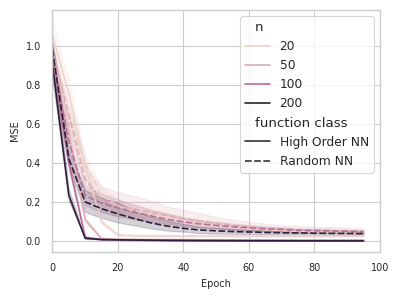

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.color_palette("colorblind")

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

df_plot = df_final[df_final['epoch'].isin(np.arange(500)*5)]
df_plot = df_plot[df_plot['metric'].isin(['MSE'])]

ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n", style="function class",
                data=df_plot)

handles, labels = ax.get_legend_handles_labels()

# ax.legend(handles=handles[1:3]+handles[4:], labels=labels[1:3]+labels[4:],ncol=2, fontsize=7, labelspacing=-0.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_xlim([0,100])
# ax.set_yscale('log')



fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("isoperimetric_training_curves.pdf")

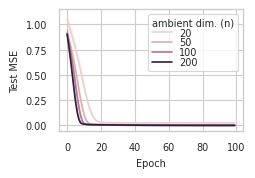

In [ ]:
sns.color_palette("colorblind")

plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

# df_plot = df_final[df_final['epoch'].isin(np.arange(500)*5)]
df_plot = df_final[df_final['function class'] == 'High Order NN']

ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n", #style="function class",
                data=df_plot)

handles, labels = ax.get_legend_handles_labels()

legend = ax.legend(handles = handles, labels = labels, fontsize=7,
                   labelspacing=-0.02, alignment = 'left',
                   title = 'ambient dim. (n)', title_fontsize = 7)
# ax.legend(handles=handles[1:3]+handles[4:], labels=labels[1:3]+labels[4:],ncol=2, fontsize=7, labelspacing=-0.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test MSE')



fig = plt.gcf()
fig.set_size_inches(2.5, 1.8)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("isoperimetric_training_curves.pdf")

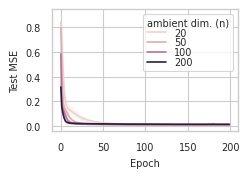

In [ ]:
sns.color_palette("colorblind")

plt.rcParams.update({'font.size': 7})
sns.set_context("paper", rc={"font.size":7,"axes.titlesize":7,"axes.labelsize":7})

# df_plot = df_final[df_final['epoch'].isin(np.arange(500)*5)]
df_plot = df_final[df_final['function class'] == 'Random NN']

ax = sns.lineplot(x="epoch", y="test_mse",
                hue="n", #style="function class",
                data=df_plot)

handles, labels = ax.get_legend_handles_labels()

legend = ax.legend(handles = handles, labels = labels, fontsize=7,
                   labelspacing=-0.02, alignment = 'left',
                   title = 'ambient dim. (n)', title_fontsize = 7)
# ax.legend(handles=handles[1:3]+handles[4:], labels=labels[1:3]+labels[4:],ncol=2, fontsize=7, labelspacing=-0.05)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.tick_params(axis='both', which='minor', labelsize=7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test MSE')



fig = plt.gcf()
fig.set_size_inches(2.5, 1.8)
plt.tight_layout()

# Save the figure as a PDF
fig.savefig("isoperimetric_training_curves_randomNN.pdf")